In [157]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow_addons.losses import metric_learning
import tensorflow_probability as tfp
from keras import backend as K
import os
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import precision_recall_curve
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [158]:

all_features = []
feature_name = ['perc_90','perc_95','perc_80','perc_5','perc_10','perc_20','diff_perc_90-80','diff_perc_20-10','diff_perc_90-10',
                'diff_perc_80-20','median','iqr','skewness']
name = 'current_stress'
all_features += [name+'_'+a for a in feature_name]
# print(len(set(all_features)),len(all_features))
name = 'current_window_stress_consecutive_diff'
all_features += [name+'_'+a for a in feature_name]
name = 'daylong_stress_likelihood_seen_so_far'
all_features += [name+'_'+a for a in feature_name]
all_features += ['fraction_of_time_stressed', 'maximum_duration_of_current_stress_episode','average_duration_of_stress_events_current_window',
               'maximum_density_of_current_stress_episode', 'average_density_of_stress_events_current_window', 'stress_deviation_to_daily_mean',
               'no_stress_till_now', 'time_since_previous_stress_event', 'duration_of_previous_stress_event', 'average_duration_of_prior_stress_events',
               'density_of_previous_stress_event', 'average_density_of_prior_stress_events', 'deviation_to_daily_mean_of_last_stress_episode',
               'fraction_of_time_stressed_seen_so_far']
all_features+= ['fraction_of_time_active_current_window', 'maximum_duration_of_current_activity_episode', 'maximum_duration_of_current_window_episode',
                 'no_activity_till_now', 'time_since_previous_activity_event', 'duration_of_previous_activity_event', 'average_duration_of_all_activity_events',
                 'fraction_of_time_active_seen_so_far']
all_features += ['time_since_last_visit_smoking_spot','average_duration_of_stay_at_smoking_spots','fraction_of_stay_duration_at_smoking_spots']
all_features += ['Gender','Age']
all_features += ['is_at_smoking_spot','location_spread','distance_to_nearest_smoking_spot',
                'time_spent_in_transition_current_window','time_spent_in_smoking_spot_current_window']
all_features += ['Time of day = {}'.format(a) for a in np.arange(24)]
feature_names = all_features


def get_X_y_groups(n_lag=10):
    data = pickle.load(open(filepath_file.format(n_lag),'rb'))

    X_feature = np.concatenate(data.feature_final.values)
    X_static =  np.concatenate(data.static_features.values)

    X_stress_episode = np.concatenate(data.stress_episode.values)
    X_quit_episode = np.concatenate(data.quit_episode.values)
    X_activity_episode = np.concatenate(data.activity_episode.values)
    X_smoking_episode = np.concatenate(data.smoking_episode.values)

    y_time = data['time'].values
    y = data['label'].values
    groups = data['user'].values
    
    return X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups

def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes


def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes

class CenterLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        alpha=0.9,
        update_centers=True,
        p = 80,
        name="center_loss",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.alpha = alpha
        self.update_centers = update_centers
        self.p = p
        
    def consistency_loss(self,labels,precise_embeddings):
        
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_positive = tf.repeat(tf.transpose(tf.reshape(tf.cast(labels,tf.bool),[lshape[0],1])),lshape[0],axis=0)
        mask_only_positive = tf.math.multiply(tf.cast(mask_for_equal,tf.float32),tf.cast(only_positive,tf.float32))
        
        pdist_matrix = metric_learning.pairwise_distance(
                    precise_embeddings, squared=False
                )
        positive_only_dist = tf.boolean_mask(pdist_matrix, tf.cast(mask_only_positive,tf.bool))
        no_of_positives = tf.cast(tf.reduce_sum(labels),tf.int32)
        positive_only_dist = tf.reshape(positive_only_dist,[no_of_positives,no_of_positives])
        positive_only_dist = tf.reduce_mean(positive_only_dist,axis=1)
        
        distance_95 = tf.reshape(positive_only_dist,(-1,))
        # if max_vs_percentile:
        #     return tf.reduce_max(distance_95),pdist_matrix
        # return tfp.stats.percentile(distance_95,self.p),pdist_matrix
        samples1 = tf.cast(no_of_positives, tf.float32) #batch size
        p = (100. - self.p)/100.  #100% will return 0 elements, 0% will return all elements
        samples = tf.cast(tf.math.floor(p * samples1), tf.int32)
        values, indices = tf.math.top_k(distance_95, samples)
        positive_dist_95th = tf.reduce_min(values)
        return positive_dist_95th, pdist_matrix
    
    
    def compute_rare_loss_v1(self,labels,pdist_matrix,positive_dist_95th):
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_negative = tf.cast(tf.repeat(tf.transpose(tf.reshape(tf.cast(1-labels,tf.bool),[lshape[0],1])),lshape[0],axis=0),tf.int32)
        mask_negative_to_positive = tf.math.logical_not(tf.cast(tf.math.add(tf.cast(mask_for_equal,tf.int32),only_negative),tf.bool))
        no_of_positives = tf.cast(tf.reduce_sum(labels),tf.int32)
        no_of_negatives = lshape[0] - no_of_positives
        negative_to_positive_distance = tf.reshape(tf.boolean_mask(pdist_matrix,mask_negative_to_positive),[no_of_negatives,no_of_positives])
        average_neg_to_pos_distance = tf.reduce_mean(negative_to_positive_distance,axis=1)
        less_distance_mask = tf.reduce_sum(tf.where(average_neg_to_pos_distance<=positive_dist_95th,1,0))
        return tf.cast(less_distance_mask,tf.float32)/(tf.cast(no_of_negatives,tf.float32)+K.epsilon())
    def call(self, sparse_labels, prelogits):
        sparse_labels = tf.reshape(sparse_labels, (-1,))
        distance_95th, pdist_matrix = self.consistency_loss(sparse_labels,prelogits)
        rare_loss = self.compute_rare_loss_v1(sparse_labels,pdist_matrix,distance_95th)
        return tf.square(rare_loss-ratio_of_pos_to_neg) + distance_95th*.2

def get_model():
    n_t,n_f = train_feature.shape[1],train_feature.shape[2]
    print(n_t,n_f)
    x_input = Input(shape=(n_t,n_f))
    x_feature = Conv1D(100,1,activation='linear')(x_input)
    x_feature = Conv1D(100,1,activation='tanh')(x_feature)
    # x_feature = Dropout(.2)(x_feature)
    x_feature = LSTM(10,activation='tanh',return_sequences=False)(x_feature)
    x_feature = Dropout(.2)(x_feature)
    x_feature = Flatten()(x_feature)
    x_feature = Dense(10,activation='relu')(x_feature)
    merged_all = x_feature
    merged1 = Dense(10,activation='relu',name='normalize2')(merged_all)
    merged1 = Lambda(lambda x: K.l2_normalize(x,axis=1),name='normalize3')(merged1)
    merged = Dense(5,activation='relu',name='normalize')(merged1)
    output = Dense(1,activation='sigmoid',name='softmax')(merged)
    model = tf.keras.models.Model(inputs=[x_input], outputs=[output,merged1])
    myloss1 = CenterLoss()
    model.compile(
        loss={'softmax':tf.losses.BinaryCrossentropy(),'normalize3':tfa.losses.TripletSemiHardLoss()},
        loss_weights = {'softmax':softmax_weight,'normalize3':revised_loss_weight},
        metrics={'softmax':['acc']},
        optimizer='adam'
        )
    return model
    
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .8
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and thresholds[i]>0.2:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
def set_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[gpu_id], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)
            
            
import shap

# we use the first 100 training examples as our background dataset to integrate over
def get_random_samples(X_feature_train,y_train):
    train_positive = X_feature_train[y_train==1]
    train_negative = X_feature_train[y_train==0]
    train_negative = train_negative[np.random.choice(np.arange(train_negative.shape[0]),train_positive.shape[0])]
    X_feature_train = np.concatenate([train_positive,train_negative])
    return X_feature_train

In [159]:
gpu_id = 1
set_gpu()

4 Physical GPUs, 1 Logical GPU


In [ ]:
n_lag = 15
obs = 30
n_cluster = 4
n_iters = 10
softmax_weight = 10
revised_loss_weight = 50
batch_size = 200
n_epochs = 500
n_step = 20
ratio_of_pos_to_neg = .3

tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
filepath_file = './data/episode_encoded_lagged_data_without_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups = get_X_y_groups(n_lag)
X_feature = np.nan_to_num(X_feature)
indexes = get_train_test_indexes(groups,n_groups_split = 3,n_val_groups=10)
explannation_data = []
for kk,yyyy in enumerate(indexes):
    train_index,test_index,val_index = yyyy
    X_feature_train,X_feature_test = X_feature[train_index],X_feature[test_index]
    X_static_train,X_static_test = X_static[train_index],X_static[test_index]
    X_stress_episode_train,X_stress_episode_test = X_stress_episode[train_index], X_stress_episode[test_index]
    X_quit_episode_train,X_quit_episode_test = X_quit_episode[train_index], X_quit_episode[test_index]
    X_activity_episode_train,X_activity_episode_test = X_activity_episode[train_index], X_activity_episode[test_index]
    X_smoking_episode_train,X_smoking_episode_test = X_smoking_episode[train_index], X_smoking_episode[test_index]
    y_train,y_test,groups_train,groups_test,time_train,time_test = y[train_index],y[test_index],groups[train_index],groups[test_index],y_time[train_index],y_time[test_index]
    
    X_feature_val,X_static_val,X_stress_episode_val,X_quit_episode_val,\
    X_activity_episode_val,X_smoking_episode_val,y_val,groups_val,time_val = X_feature[val_index],X_static[val_index],X_stress_episode[val_index],X_quit_episode[val_index],\
                                                                            X_activity_episode[val_index],X_smoking_episode[val_index],y[val_index],groups[val_index],y_time[val_index]
    
    X_feature_train,val_feature,\
    X_static_train,val_static,\
    X_stress_episode_train,val_stress,\
    X_smoking_episode_train,val_smoking,\
    X_quit_episode_train,val_quit,\
    X_activity_episode_train,val_activity, \
    y_train,val_y = train_test_split(
                                    X_feature_train,
                                    X_static_train,
                                    X_stress_episode_train,
                                    X_smoking_episode_train,
                                    X_quit_episode_train,
                                    X_activity_episode_train,
                                    y_train,
                                    test_size=.05,
                                    stratify=y_train
                                    )
    val_feature = np.concatenate([val_feature,X_feature_val])
    val_static = np.concatenate([val_static,X_static_val])
    val_stress = np.concatenate([val_stress,X_stress_episode_val])
    val_activity = np.concatenate([val_activity,X_activity_episode_val])
    val_smoking = np.concatenate([val_smoking,X_smoking_episode_val])
    val_quit = np.concatenate([val_quit,X_quit_episode_val])
    val_y = np.array(list(val_y)+list(y_val))
    
    positive_train_index = np.where(y_train==1)[0]
    negative_train_index = np.where(y_train==0)[0]
    len_positive = len(positive_train_index)
    all_models = []
    for iter in range(n_iters):
        indexes_sampled = np.array(list(positive_train_index)+list(np.random.choice(negative_train_index,len_positive,replace=False)))
        train_feature = np.float64(X_feature_train[indexes_sampled])
        train_static = X_static_train[indexes_sampled]
        train_stress = X_stress_episode_train[indexes_sampled]
        train_quit = X_quit_episode_train[indexes_sampled]
        train_activity = X_activity_episode_train[indexes_sampled]
        train_smoking = X_smoking_episode_train[indexes_sampled]
        train_y = np.float64(y_train[indexes_sampled])
        model = get_model()
        # model.summary()
        validation_results = [0]
        counter_ = 0
        best_filepath = None
        for iiii in np.arange(0,n_epochs,n_step):
            filepath = './models/lag_'+str(n_lag)+'_iter_'+str(n_iters)+'_temp_with_episode_revised_loss_80_.2{}{}{}{}.hdf5'.format(softmax_weight,revised_loss_weight,ratio_of_pos_to_neg,iiii)
            checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=False)
            es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=60)
            callbacks_list = [es,checkpoint]
            model.fit(train_feature,[train_y,train_y],
                      epochs=n_step, batch_size=batch_size,
                      verbose=0,callbacks=callbacks_list,shuffle=True)
            if os.path.isfile(filepath):
                model.load_weights(filepath)
            val_y_pred = model.predict(val_feature)[0]
            val_f1_now = f1Bias_scorer_CV(val_y_pred,val_y)[0]
            # print('<->'*20)
            from sklearn.metrics import roc_auc_score
            print('Validation Result now',val_f1_now,'AUC',roc_auc_score(val_y,val_y_pred),'step',iiii,'stagnant',counter_)
            # print('<->'*20)
            if val_f1_now>=max(validation_results):
                best_filepath = filepath
                counter_ = 0
            else:
                counter_ += n_step
                if counter_>200:
                    break
            validation_results.append(val_f1_now)
        if os.path.isfile(best_filepath):
            print()
            print(best_filepath[-15:])
            model.load_weights(best_filepath)
        model_this_iter = tf.keras.models.Model(model.input,model.get_layer('softmax').output)
        all_models.append(model_this_iter)
        print(len(all_models))
    model_input = all_models[0].input
    model_outputs = [model(model_input) for model in all_models]
    ensemble_output = tf.keras.layers.Average()(model_outputs)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    train_data = get_random_samples(X_feature_train,y_train)
    test_data = get_random_samples(X_feature_test,y_test)
    explainer = shap.DeepExplainer(ensemble_model,train_data)
    shap_values = explainer.shap_values(test_data,check_additivity=False)
    plt.figure()
    shap.summary_plot([shap_values[0].mean(axis=1)], test_data.mean(axis=1),feature_names=feature_names)
    plt.show()
    explannation_data.append([shap_values,test_data])
    pickle.dump(explannation_data,open('./data/explannation_data.p','wb'))

In [ ]:
model_input = all_models[0].input
model_outputs = [model(model_input) for model in all_models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.predict(X_feature_test).shape,X_feature_test.shape,y_test.shape,X_feature_train.shape,y_train.shape
ensemble_model.summary()
import shap

# we use the first 100 training examples as our background dataset to integrate over
def get_random_samples(X_feature_train,y_train):
    train_positive = X_feature_train[y_train==1]
    train_negative = X_feature_train[y_train==0]
    train_negative = train_negative[np.random.choice(np.arange(train_negative.shape[0]),train_positive.shape[0])]
    X_feature_train = np.concatenate([train_positive,train_negative])
    return X_feature_train
train_data = get_random_samples(X_feature_train,y_train)
test_data = get_random_samples(X_feature_test,y_test)

explainer = shap.DeepExplainer(ensemble_model,X_feature_train)
shap_values = explainer.shap_values(test_data,check_additivity=False)
# shap_values[0].sum(axis=1).
# 


?shap.summary_plot

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0].sum(axis=1)[0], val_feature.mean(axis=1)[0],feature_names=feature_names)

In [ ]:
?shap.summary_plot

In [ ]:
import pickle
import shap
import numpy as np

In [ ]:
unwanted = ['fraction_of_time_stressed_seen_so_far','fraction_of_time_active_current_window']
filenames = [
            # 'explannation_data.p',
            #  'explannation_data_v1.p',
            #  'explannation_data_v3.p',
            #  'explannation_data_v4.p',
             'explannation_data_v5.p',
            #  'explannation_data_v6.p'
            ]
index = np.array([i for i,a in enumerate(feature_names) if a.split(' ')[0]!='Time' and a.split('_')[0]!='daylong' and a.split('_')[0]!='maximum' and a not in unwanted])

for filename in filenames:
    data = pickle.load(open('./data/'+filename,'rb'))
    df_col = []
    for a,b in data:
        shap_value = []
        test_data = []
        shap_value.append(np.abs(a[0][:,:,index]).mean(axis=1))
        test_data.append(b[:,:,index].mean(axis=1))
        shap.summary_plot([np.concatenate(shap_value)], np.concatenate(test_data),feature_names=np.array(feature_names)[index],max_display = 10)
    # plt.xlabel('')
    # ax = plt.gca()
    # ax.set_xlabel('')
    # print(len(data))

In [ ]:
np.concatenate(np.abs(shap_value)).mean(axis=0).shape


In [ ]:
np.array(feature_names)[index]

In [ ]:
a[0].shape

In [213]:
# shap.summary_plot(np.concatenate(shap_value), np.concatenate(test_data),feature_names=feature_names)
all_features = []
feature_name = ['90_prctile','95_prctile','80_prctile','5_prctile','10_prctile','20_prctile','diff_prctile_90-80','diff_prctile_20-10','diff_prctile_90-10',
                'diff_prctile_80-20','median','iqr','skewness']
name = 'current_stress'
all_features += [a+'_of_'+name for a in feature_name]
# print(len(set(all_features)),len(all_features))
name = 'current_window_stress_consecutive_diff'
all_features += [a+'_of_'+name for a in feature_name]
name = 'stress_likelihood_until_obs'
all_features += [a+'_of_'+name for a in feature_name]
all_features += ['fraction_of_time_stressed_current_window', 'maximum_duration_of_current_stress_episode','average_duration_of_stress_events_current_window',
               'maximum_density_of_current_stress_episode', 'average_density_of_stress_events_current_window', 'stress_deviation_to_daily_mean',
               'no_stress_till_now', 'time_since_previous_stress_event', 'duration_of_previous_stress_event', 'average_duration_of_stress_events_until_obs',
               'density_of_previous_stress_event', 'average_density_of_stress_events_until_obs', 'deviation_to_daily_mean_of_last_stress_episode',
               'fraction_of_time_stressed_until_obs']
all_features+= ['fraction_of_time_active_current_window', 'maximum_duration_of_current_activity_episode', 'maximum_duration_of_current_window_episode',
                 'no_activity_till_now', 'time_since_previous_activity_event', 'duration_of_previous_activity_event', 'average_duration_of_activity_events_until_obs',
                 'fraction_of_time_active_until_obs']
all_features += ['time_since_last_visit_to_smoking_spot','average_duration_of_stay_at_smoking_spots','fraction_of_stay_duration_at_smoking_spots_until_obs']
all_features += ['Gender','Age']
all_features += ['is_at_smoking_spot','location_spread','distance_to_nearest_smoking_spot',
                'time_spent_in_transition_current_window','time_spent_in_smoking_spot_current_window']
all_features += ['Hour of day = {}'.format(a) for a in np.arange(24)]
feature_names = all_features


In [214]:
# feature_names

all_features = []
feature_name = ['p90','p95','p80','p5','p10','p20','range_90_to_80','range_20_to_10','range_90_to_10',
                'range_80_to_20','median','iqr','skew']
name = 'current_window_stress'
all_features += [name+'_'+a for a in feature_name]
# print(len(set(all_features)),len(all_features))
name = 'current_window_stress_diff'
all_features += [name+'_'+a for a in feature_name]
name = 'daily_stress'
all_features += [name+'_'+a for a in feature_name]
all_features += ['percentage_of_stress', 'maximum_duration_of_current_stress_episode','average_duration_of_current_stress_episode',
               'maximum_density_of_current_stress_episode', 'average_density_of_current_stress_episode', 'average_deviation_to_daily_mean_current',
               'no_stress_till_now', 'time_since_last_stress', 'duration_of_last_stress_episode', 'average_duration_of_before_stress_episode',
               'density_of_last_stress_episode', 'average_density_of_before_stress_episode', 'deviation_to_daily_mean_of_last_stress_episode',
               'percentage_of_stress_before']
all_features+= ['percentage_of_active_', 'maximum_duration_of_current_activity_episode', 'average_duration_of_current_window_episode',
                 'no_activity_till_now', 'time_since_last_activity', 'duration_of_last_activity_episode', 'average_duration_of_before_activity_episode',
                 'percentage_of_active_before']
all_features += ['time_since_last_visit_smoking_spot','duration_of_stay_in_smoking_spot','fraction_of_minutes_spent_in_smoking_spots_out_of_observed']
all_features += ['Gender','Age']
all_features += ['is_smoking','spread','distance_to_nearest_spot',
                'time_spent_in_transition','time_spent_in_smoking_spot']
all_features += ['Time of day = {}'.format(a) for a in np.arange(24)]

In [215]:
feature_name_change = {all_features[i]:a for i,a in enumerate(feature_names)}

In [231]:
df = pickle.load(open('./data/ig_dataframe.p','rb'))

In [232]:
df['name'] = df['name'].apply(lambda a:feature_name_change[a])

In [233]:
df['name'][df['name']=='Hour of day = 17'] = 'Hour of day'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [234]:
df

,importance,name,weight,iter
0,0.001323,90_prctile_of_current_stress,./explannation_models/10_50_35.0/0/0.h5,0
1,0.001971,95_prctile_of_current_stress,./explannation_models/10_50_35.0/0/0.h5,0
2,0.000888,80_prctile_of_current_stress,./explannation_models/10_50_35.0/0/0.h5,0
3,0.001080,5_prctile_of_current_stress,./explannation_models/10_50_35.0/0/0.h5,0
4,0.001619,10_prctile_of_current_stress,./explannation_models/10_50_35.0/0/0.h5,0
...,...,...,...,...
90,0.037239,Hour of day = 19,./explannation_models/10_50_35.0/2/29.h5,2
91,0.012439,Hour of day = 20,./explannation_models/10_50_35.0/2/29.h5,2
92,0.014208,Hour of day = 21,./explannation_models/10_50_35.0/2/29.h5,2
93,0.009172,Hour of day = 22,./explannation_models/10_50_35.0/2/29.h5,2


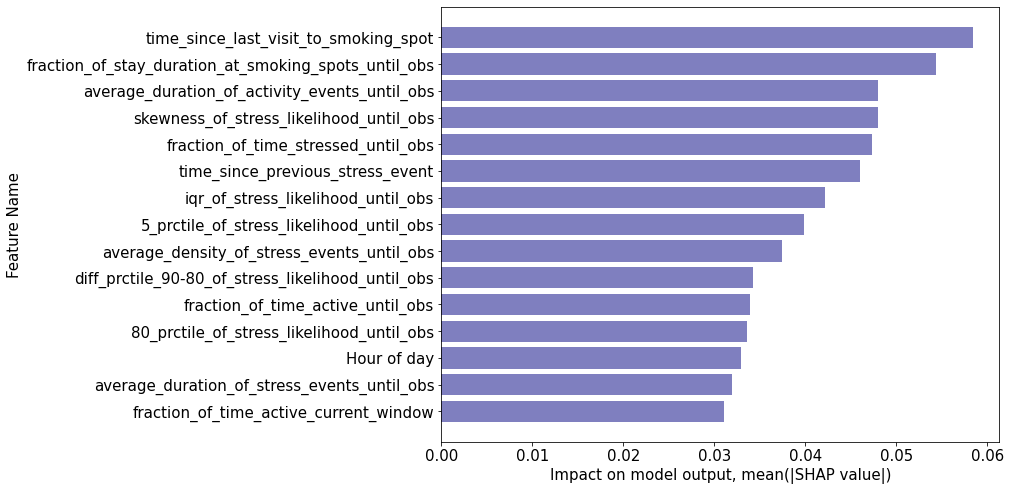

In [235]:
import seaborn as sns
max_df = df.groupby('name',as_index=False).mean().sort_values('importance')[-15:]
std_df = df[df.name.isin(max_df.name.values)].groupby('name',as_index=False).std()
# df.groupby('name',as_index=False).mean().sort_values('importance')[-10:][::-1]
# max_df,std_df
max_df = pd.merge(max_df,std_df,on='name')

plt.rcParams.update({'font.size':15})
plt.figure(figsize=(10,8))
# sns.barplot(y='name',x='importance',data=max_df,orient='h')
plt.barh(max_df['name'].values,max_df['importance_x'].values,
         color = 'navy',alpha=.5)
plt.xlabel('Impact on model output, mean(|SHAP value|)')
plt.ylabel('Feature Name')
# plt.tight_layout()
plt.show()